In [1]:
%run init.ipynb

In [2]:
from qiskit import *

### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

# O experimento da bomba de Elitzur e Vaidman
Consideremos o experimento de Mach-Zehnder, com uma bomba sensível a um único fóton colocada no caminho vertical, depois do espelho. Vale observar que o que veremos valeria para qualquer objeto absorvedor de luz. Veja a figura abaixo.
<img src = 'fig_bomba.png' width = '300'>

Ao passar pelo divisor de feixes, o fóton é colocado em um estado de superposição, seguindo pelos dois caminhos. A bomba funciona como um detector. Então, com probabilidade $1/2$ esta explodirá e com probabilidade 1/2 não acontecerá nada. 

No caso do estado de posição do fóton colapsar para o caminho onde a bomba não está, quando o fóton chegar ao segundo divisor de feixes, terá também 50% de chance de ser ou não ser refletido. Quando comparado ao caso em que a bomba não existe, para o qual 
$$Pr(1)=0, \text{sem a bomba.}$$
quando a bomba está presente, teremos uma probabilidade
$$(1/2)(1/2) = 1/4 = Pr(1), \text{com a bomba,}$$
de detectarmos a bomba sem explodí-la.

Esse efeito foi chamado de __medida livre de interação__, pois detectamos a presença da bomba sem o fóton ter interagido com ela (embora essa afirmação seja discutível). Também chama-se esse tipo de fenômeno de contra-factual. Alguns usam esse experimento para argumentar que a interpretação de muitos mundos de Everett seria adequada para explicar o que acontece aqui (a bomba sempre explode, mas as vezes explode em outro universo).

Vamos simular o processo de medida da bomba a tratando como um qubit que se emaranha com o fóton. Ou seja, identificamos
\begin{cases}
|0\rangle \equiv \text{ bomba não explodiu}, \\
|1\rangle \equiv \text{ bomba explodiu}.
\end{cases}
Inicialmente a bomba está no estado $|0\rangle$. O processo de medida da _bomba atua como a placa de quarto de onda_, que vimos quando da discussão sobre o apagador quântico. Ou seja
$$U_{b} = |0\rangle\langle0|\otimes I + |1\rangle\langle 1|\otimes X.$$
Como o estado do fóton imediatamente antes da bomba é
$$(-|0\rangle+i|1\rangle)/\sqrt{2},$$
depois que a bomba atua, teremos o estado
$$U_{b}(-|0\rangle_{f}+i|1\rangle_{f})|0\rangle_{b}/\sqrt{2} = (-|00\rangle_{fb}+i|11\rangle_{fb})/\sqrt{2}.$$
Finalmente, atuando o último divisor de feixes, obteremos o estado
\begin{align}
& \frac{1}{2}\big(-(|0\rangle_{f}+i|1\rangle_{f})|0\rangle_{b}+i(i|0\rangle_{f}+|1\rangle_{f})|1\rangle_{b})\big) \\
& = \frac{1}{2}\big(-|00\rangle_{fb}-i|10\rangle_{fb}-|01\rangle_{fb}+i|11\rangle_{fb}\big).
\end{align}
Assim, a probabilidade do fóton chegar em D1 e a bomba não explodir é
$$Pr(10) = |c_{10}|^{2} = |-i/2|^{2} = \frac{1}{4}.$$

Abaixo está a implementação do experimento da bomba de Elitzur-Vaidman usando o IBMQ.

In [3]:
nshots = 8192
qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
simulator = Aer.get_backend('qasm_simulator')
device = provider.get_backend('ibmq_bogota')
from qiskit.tools.visualization import plot_histogram
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.tools.monitor import job_monitor, backend_overview, backend_monitor

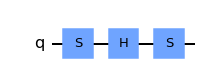

In [4]:
def qc_df():
    qc = QuantumCircuit(1, name = 'DF')
    qc.s(0); qc.h(0); qc.s(0)
    return qc
qc_df_ = qc_df(); qc_df_.draw(output = 'mpl')

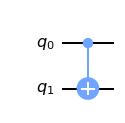

In [5]:
def qc_bomb():
    qc = QuantumCircuit(2, name = 'bomba')
    qc.cx(0,1)
    return qc
qc_bomb_ = qc_bomb(); qc_bomb_.draw(output = 'mpl')

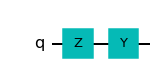

In [6]:
def qc_espelho():
    qc = QuantumCircuit(1, name = 'espelho')
    qc.z(0); qc.y(0)
    return qc
qc_espelho_ = qc_espelho(); qc_espelho_.draw(output = 'mpl')

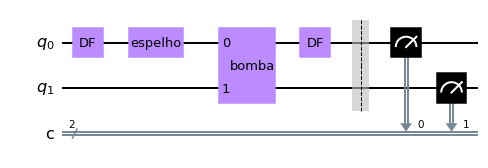

In [7]:
qc = QuantumCircuit(2, 2)
qc_df_ = qc_df(); qc.append(qc_df_, [0])
qc_espelho_ = qc_espelho(); qc.append(qc_espelho_, [0])
qc_bomb_ = qc_bomb(); qc.append(qc_bomb_, [0,1])
qc.append(qc_df_, [0]); qc.barrier()
qc.measure([0,1],[0,1])
qc.draw(output = 'mpl')

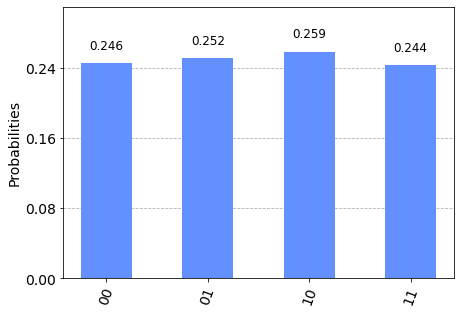

In [8]:
job = qiskit.execute(qc, backend = simulator, shots = nshots)
plot_histogram(job.result().get_counts(qc))

In [44]:
job = qiskit.execute(qc, backend = device, shots = nshots)
print(job.job_id()); job_monitor(job)

61def0fd87d4f857d12400e2
Job Status: job has successfully run


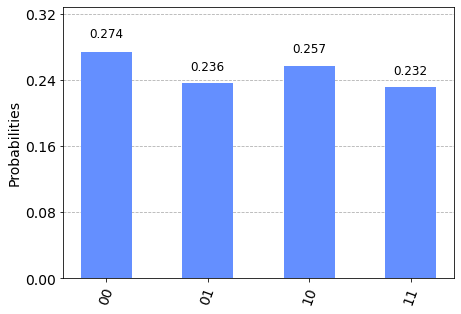

In [45]:
plot_histogram(job.result().get_counts(qc))

OBS: Esse conceito de medida livre de interação é realmente interessante. Podemos pensar e.g. e fazer uma imagem de raios X "sem" jogar raiox X sobre a amostra (evitando câncer, por exemplo). A seguir discutiremos uma maneira de chegar mais próximo do "sem". Em relação a isso, observamos que um estado puro geral para o fóton e a bomba é
$$c_{00}|00\rangle + c_{01}|01\rangle + c_{10}|10\rangle + c_{11}|11\rangle.$$
O que queremos é fazer operações que nos levem ao valor máximo do módulo do coeficiente $c_{10}$:
$$U=? \ |\ \max|c_{10}|^{2}.$$

## Divisor de feixes geral
Ao invés de considerar um divisor de feixes (DF) com refletividade 50%, como feito acima, vamos considerar um divisor de feixes com uma refletividade geral (DFG). Temos que
\begin{cases}
R^{2} = \text{ probabilidade do fóton ser refletido} = \text{ taxa temporal de fótons refletidos}, \\
T^{2} = \text{ probabilidade do fóton ser transmitido} = \text{ taxa temporal de fótons transmitidos}.
\end{cases}
Devemos ter portanto
$$R^{2}+T^{2}=1.$$

Neste caso geral, o efeito do DFG será
\begin{cases}
|0\rangle \rightarrow T|0\rangle+iR|1\rangle, \\
|1\rangle \rightarrow T|1\rangle+iR|0\rangle.
\end{cases}
Com isso, vem que
\begin{align}
U_{dfg}|\psi\rangle & = \begin{bmatrix}U_{11}&U_{12}\\U_{21}&U_{22}\end{bmatrix}\begin{bmatrix}c_{0}\\c_{1}\end{bmatrix} \\
& = c_{0}U_{dfg}|0\rangle + c_{1}U_{dfg}|1\rangle =  c_{0}(T|0\rangle+iR|1\rangle) + c_{1}(T|1\rangle+iR|0\rangle) \\
& = (Tc_{0}+iRc_{1})|0\rangle + (iRc_{0}+Tc_{1})|1\rangle = \begin{bmatrix}Tc_{0}+iRc_{1}\\iRc_{0}+Tc_{1}\end{bmatrix}.
\end{align}
Portanto, a matriz unitária que representa o DFG é:
$$U_{dfg} \doteq \begin{bmatrix}T&iR\\iR&T\end{bmatrix} := \begin{bmatrix}\cos\theta&i\sin\theta\\i\sin\theta&\cos\theta\end{bmatrix} = U_{dfg}(\theta),$$
em que definimos
$$T:=\cos\theta \text{ e } R = \sin\theta.$$
Assim, para $\theta\in[0,\pi/2]$ teremos $T\in[1,0]$ e $R\in[0,1]$.

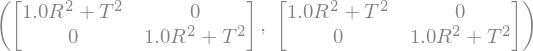

In [47]:
T, R = symbols('T R'); Udfg = Matrix([[T,1j*R],[1j*R,T]]); Udfgd = Matrix([[T,-1j*R],[-1j*R,T]])
Udfg*Udfgd, Udfgd*Udfg # ok, é unitária

Claro, teremos o caso especial 
$$U_{df} = U_{dfg}(\theta = \pi/4) = U_{dfg}(T = R = 1/\sqrt{2}).$$

Ademais, como 
$$RX(\theta) = e^{-iX\theta/2} = I\cos(\theta/2) -iX\sin(\theta/2) = \begin{bmatrix}\cos(\theta/2)&-i\sin(\theta/2)\\-i\sin(\theta/2)&\cos(\theta/2)\end{bmatrix},$$
temos que
$$ U_{dfg}(\theta) = RX(-2\theta).$$

### Mach-Zehnder com divisor de feixes geral
Considere o interferômetro de Mach-Zehnder (IMZ) da figura abaixo, mas os divisores de feixes (DFs) gerais.
<img src='fig_imz.png' width='300'>
Teremos a seguinte sequência de estados
\begin{align}
& |0\rangle \stackrel{DFG}{\longrightarrow} \cos\theta|0\rangle + i\sin\theta|1\rangle  \\
& \stackrel{E}{\longrightarrow} i\cos\theta|1\rangle + i^{2}\sin\theta|0\rangle \\
& \stackrel{\phi}{\longrightarrow} ie^{i\phi}\cos\theta|1\rangle - \sin\theta|0\rangle \\
& \stackrel{DFG}{\longrightarrow} ie^{i\phi}\cos\theta(\cos\theta|1\rangle+i\sin\theta|0\rangle) - \sin\theta(\cos\theta|0\rangle+i\sin\theta|1\rangle) \\
& = -\sin\theta\cos\theta(e^{i\phi}+1)|0\rangle +i\big(e^{i\phi}\cos^{2}\theta-\sin^{2}\theta\big)|1\rangle.
\end{align}
Assim
\begin{align}
Pr(D_{0}) & = \sin^{2}\theta\cos^{2}\theta|1+e^{i\phi}|^{2} = 2\sin^{2}\theta\cos^{2}\theta(1+\cos\phi) \\
& = 2T^{2}R^{2}(1+\cos\phi)
\end{align}
e, usando $Pr(D_{0})_{\max} = 2T^{2}R^{2}(1+\cos0) = 4T^{2}R^{2}$ e $Pr(D_{0})_{\min} = 2T^{2}R^{2}(1+\cos\pi) = 0$, obteremos a visibilidade
\begin{align}
V = \frac{P_{\max}-P_{\min}}{P_{\max}+P_{\min}} = \frac{4T^{2}R^{2} - 0}{4T^{2}R^{2} + 0} = 1.
\end{align}
Este resultado parece estranho.

Abaixo simulamos o IMZ com DFG.

OBS: Vale observar que se $\phi=0$, termos $Pr(0)=1$ somente se $\theta=\pi/4\ \therefore\ DFG\equiv DF$.

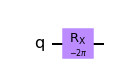

In [9]:
def qc_dfg(th):
    qc = QuantumCircuit(1, name = 'DFG')
    qc.rx(-2*th, 0)
    return qc
qc_dfg_ = qc_dfg(math.pi); qc_dfg_.draw(output = 'mpl')

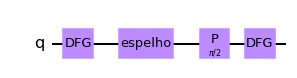

In [10]:
def qc_imzg(th, ph):
    qc = QuantumCircuit(1, name = 'IMZG')
    qc_dfg_ = qc_dfg(th); qc.append(qc_dfg_, [0])
    qc_espelho_ = qc_espelho(); qc.append(qc_espelho_, [0])
    qc.p(ph, 0)
    qc_dfg_ = qc_dfg(th); qc.append(qc_dfg_, [0])
    return qc
qc_imzg_ = qc_imzg(math.pi, math.pi/2); qc_imzg_.draw(output = 'mpl')

In [12]:
phmax = 2*math.pi; dph = phmax/20; ph = np.arange(0, phmax+dph, dph)#; ph
th = math.pi/8
print('T = ', math.cos(th), ', R = ', math.sin(th))
d = ph.shape[0]; PD0teo = np.zeros(d); PD0sim = np.zeros(d);
for j in range(0, d):
    PD0teo[j] = 2*math.sin(th)**2*math.cos(th)**2*(1+math.cos(ph[j])) # theoretical
    qc = QuantumCircuit(1)
    qc_imzg_ = qc_imzg(th, ph[j]); qc.append(qc_imzg_, [0])
    qstc = state_tomography_circuits(qc, [0]) # circuit for state tomography
    job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc); rho = qstf.fit(method='lstsq')
    PD0sim[j] = rho[0,0].real

T =  0.9238795325112867 , R =  0.3826834323650898


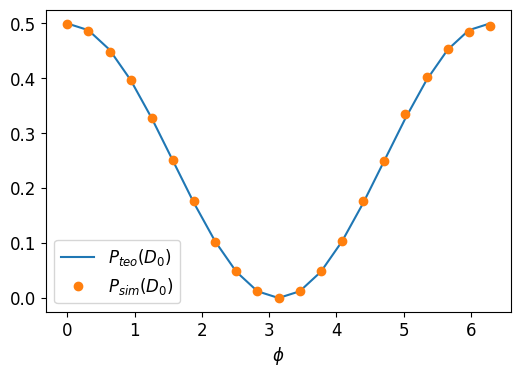

In [13]:
matplotlib.rcParams.update({'font.size':12}); plt.figure(figsize = (6,4), dpi = 100)
plt.plot(ph, PD0teo, label = r'$P_{teo}(D_{0})$')
plt.plot(ph, PD0sim, 'o', label = r'$P_{sim}(D_{0})$')
#plt.plot(ph, PD0exp, '*', label = r'$P_{exp}(D_{0})$')
plt.legend(); plt.xlabel(r'$\phi$'); plt.show()

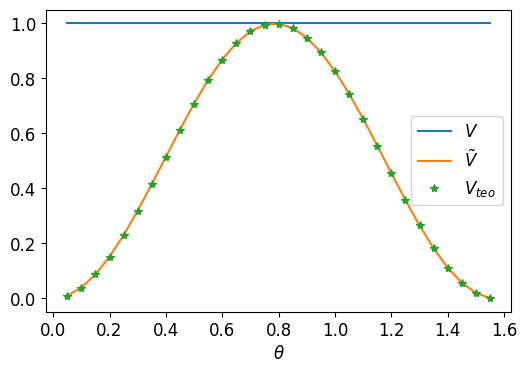

In [14]:
def V(pd):
    return (np.max(pd)-np.min(pd))/(np.max(pd)+np.min(pd))
def Vt(pd):
    return np.max(pd)*(np.max(pd)-np.min(pd))/(np.max(pd)+np.min(pd))
def pd_ph(th):
    phmax = 2*math.pi; dph = phmax/100; ph = np.arange(0, phmax+dph, dph)
    return 2*math.sin(th)**2*math.cos(th)**2*(1+np.cos(ph))

dth = 0.05; th = np.arange(dth, math.pi/2, dth); d = th.shape[0]
Vis = np.zeros(d); VisT= np.zeros(d); Vteo = np.zeros(d)
for j in range(0, d):
    Vteo[j] = 4*math.cos(th[j])**2*math.sin(th[j])**2
    pd = pd_ph(th[j]); Vis[j] = V(pd); VisT[j] = Vt(pd)
    
matplotlib.rcParams.update({'font.size':12}); plt.figure(figsize = (6,4), dpi = 100)
plt.plot(th, Vis, label = r'$V$'); plt.plot(th, VisT, label = r'$\tilde{V}$')
plt.plot(th, Vteo, '*', label = r'$V_{teo}$')
plt.xlabel(r'$\theta$'); plt.legend(); plt.show()

Acho que é a definição de visibilidade que está errada, pois sempre que $P_{\min}=0$ teremos $V=1$:
$$V(P_{\min}=0) = \frac{P_{\max}-P_{\min}}{P_{\max}+P_{\min}} = \frac{P_{\max}-0}{P_{\max}+0} = 1,$$
independentemente do valor de $P_{\max}$. Acredito que isto esteja errado pois a intenção da visibilidade é quantificar o contraste do padrão de interferência, que será máximo somente quando
$$P_{\max} = 1 \text{ e } P_{\min}=0.$$
Pode-se remediar essa questão usando a seguinte medida de visibilidade de padrão de interferência
$$\tilde{V} = P_{\max}\frac{P_{\max}-P_{\min}}{P_{\max}+P_{\min}}.$$
Nesse caso, teríamos
$$\tilde{V} = 4T^{2}R^{2},$$
que também mostramos no gráfico acima.

## Efeito Zenão quântico
Esse efeito é ilustrado na figura abaixo (retirada de (Phys. Rev. Lett. 74, 4763 (1995)).
<img src = 'fig_zeno_optics.png' width = '500'>

Vamos fazer algo similar aqui. Consideremos um qubit preparado inicialmente no estado (representa a polarização horizontal)
$$|\psi_{0}\rangle = |0\rangle.$$
A rotação de polarização será simulada pela operação
$$RX(\theta) = e^{-iX\theta/2} = I\cos(\theta/2) -iX\sin(\theta/2).$$
Aqui observamos que
$$RX(\theta)RX(\phi) = RX(\theta+\phi).$$
Portanto
$$\Pi_{j=1}^{N}RX(\theta/N) = RX(\theta).$$
Ademais
$$RX(\theta)|0\rangle = \cos(\theta/2)|0\rangle -i\sin(\theta/2)|1\rangle.$$
Então
$$RX(\pi)|0\rangle = -i|1\rangle =: |\psi\rangle \ \therefore\ Pr(0|\psi) = 0.$$
De outra forma, teremos e.g. que
$$RX(\pi)|0\rangle = \Pi_{j=1}^{6}RX(\pi/6)|0\rangle = -i|1\rangle =: |\psi\rangle \ \therefore\ Pr(0|\psi) = 0.$$

Vejamos agora o que ocorre se intercalamos as rotações de polarização $RX(\pi/6)$ com medidas na base computacional com pós-seleção do estado $|0\rangle$. Cada sub-rotação aplicada neste estado nos fornece:
$$RX(\pi/6)|0\rangle = \cos(\pi/12)|0\rangle -i\sin(\pi/12)|1\rangle =: |\psi_{1}\rangle \ \therefore\ Pr(0|\psi_{1}) = \cos^{2}(\pi/12).$$
Depois de 6 aplicações do par (rotação, medida com pós-seleção), a probabilidade de obtermos o estado $|0\rangle$ será
$$Pr(0) = \big(\cos^{2}(\pi/12)\big)^{6} \approx 0,66.$$
Ou seja, pela ação repetida de medidas e pós-seleção, aumentamos a probabilidade (intensidade da luz) de $0\ \%$ para $66\ \%$ da quantidade de entrada.

Claro, se aumentamos o número de sub-rotações + medida com pós-seleção, aumentamos a probabilidade $Pr(0)$. Por exemplo, para $\Pi_{j=1}^{12}RX(\pi/12) = RX(\pi)$, teremos
$$ Pr(0) = \big(\cos^{2}(\pi/24)\big)^{12} \approx 0,81.$$
Para $\Pi_{j=1}^{24}RX(\pi/24) = RX(\pi)$, teremos
$$ Pr(0) = \big(\cos^{2}(\pi/48)\big)^{24} \approx 0,90.$$
Para $\Pi_{j=1}^{48}RX(\pi/48) = RX(\pi)$, teremos
$$ Pr(0) = \big(\cos^{2}(\pi/96)\big)^{48} \approx 0,95.$$

In [15]:
float(cos(pi/12)**2)

In [16]:
float((cos(pi/12)**2)**6), float((cos(pi/24)**2)**12), float((cos(pi/48)**2)**24), float((cos(pi/96)**2)**48)

## Diminuindo a probabilidade da bomba explodir
Para aumentarmos a chance de detecção da bomba sem esta explodir, usamos o efeito Zenão quântico. Notemos que as duas operações importantes no contexto do IZM do experimento de Elitzur-Vaidman são os dois DF, e que
$$U_{df}U_{df} = U_{dfg}(\pi/4)U_{dfg}(\pi/4) = U_{dfg}(\pi/2) = RX(-\pi).$$ Podemos aplicar e.g.
$$\Pi_{j=1}^{6}RX(-\pi/6) = RX(-\pi).$$
Cada rotação $RX(-\pi/6)$ equivale a fazer o fóton passar pelo DFG, $U_{dfg}(\pi/12)$. Depois disso o fóton interage com a bomba, o que é modelado pela CNOT. Depois disso, fazemos uma medida projetiva com pós-seleção do estado da bomba. O fóton passa por esse processo 5 vezes, e finalmente passa mais uma vez pelo DFG. Depois disso, medimos o estado de caminho do fóton. 

Motivado pelos resultados abaixo, vamos analisar o IMZ. Se fazemos $\phi=0$ no IMZ, este funciona como uma transformação unitária 
$$U_{imz} = U_{df}U_{e}U_{df} = -I,$$
conforme verificado com o código abaixo. Portanto
$$U_{imz}|0\rangle = -|0\rangle = e^{i\pi}|0\rangle.$$

Temos que $U_{e} = \begin{bmatrix}0&i\\i&0\end{bmatrix} = U_{dfg}(\pi/2)$. Teremos assim que 
$$U_{df}U_{e}U_{df} = U_{dfg}(\pi/4)U_{dfg}(\pi/2)U_{dfg}(\pi/4) = U_{dfg}(\pi) = RX(-2\pi)$$
e
$$U_{dfg}(\pi)|0\rangle = RX(-2\pi)|0\rangle = -|0\rangle.$$

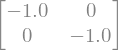

In [90]:
Udf = (1/sqrt(2))*Matrix([[1,1j],[1j,1]]); Ue = Matrix([[0,1j],[1j,0]]); Udf*Ue*Udf

In [ ]:
T = cos(math.pi/12); T

Vamos fazer as contas
\begin{align}
& |00\rangle_{fb} \rightarrow\ (R_{x}(\theta)\otimes I)|00\rangle_{fb} = (\cos(\theta/2)|0\rangle_{f} - i\sin(\theta/2)|1\rangle_{f})\otimes|0\rangle_{b} \\
& \xrightarrow[]{\text{espelho}} (i\cos(\theta/2)|1\rangle_{f} + \sin(\theta/2)|0\rangle_{f})\otimes|0\rangle_{b} \\
& \xrightarrow[]{bomba} i\cos(\theta/2)|11\rangle_{fb} + \sin(\theta/2)|00\rangle_{fb} \\
& \xrightarrow[]{medida, pós-seleção} |00\rangle_{fb} \text{ com prob. } \sin^{2}(\theta/2).
\end{align}
Ao aplicar essa sequência de operações, com as pós-seleções, obteremos então o estado 
$$|00\rangle_{fb} \text{ com probabilidade } \sin^{10}(\theta/2).$$
Aplicando o último DFG, teremos
$$|00\rangle_{fb} \xrightarrow[]{DFG} \cos(\theta/2)|00\rangle_{fb} + i\sin(\theta/2)|10\rangle_{fb}.$$
Por conseguinte, a probabilidade de detectar o fóton no detector $D_{1}$ sem explodir a bomba é
$$Pr(D_{1}) = \big(\sin^{2}(\theta/2)\big)^{6}.$$

In [36]:
th = +pi-pi/6; float((sin(th/2)**2)**6)

In [35]:
T = cos(th); R = sin(th); print('T = ', float(T), ', R = ', float(R)) # ??????????????

T =  -0.8660254037844386 , R =  -0.5


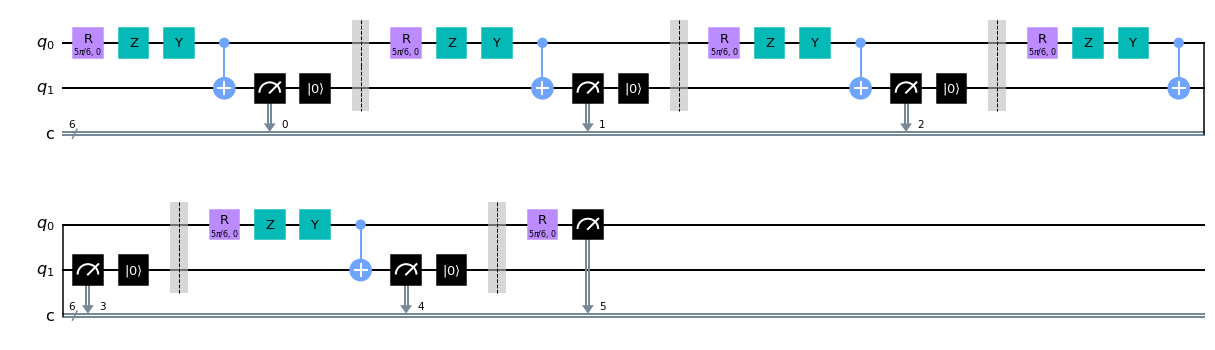

In [18]:
N = 6; th = math.pi-math.pi/N; qc = QuantumCircuit(2, N)
for j in range(0, N-1):
    qc.rx(th, 0)
    qc_espelho_ = qc_espelho(); qc.append(qc_espelho_, [0])
    qc.cx(0, 1); qc.measure(1, j); qc.reset(1)
    qc.barrier()
qc.rx(th, 0) # o último DFG é colocado só na última volta
qc.measure(0, N-1)
#qc.draw(output = 'mpl')
qc.decompose().draw(output = 'mpl')

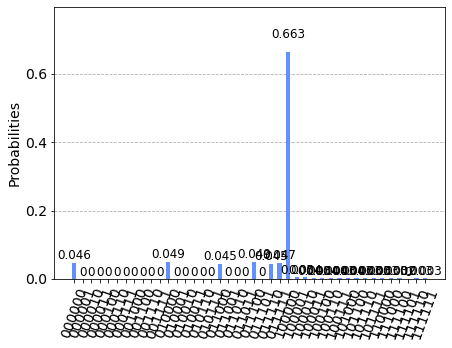

In [19]:
matplotlib.rcParams.update({'font.size':12})
#plt.figure(figsize = (6,4), dpi = 100)
result = execute(qc, backend = simulator, shots = nshots).result()
plot_histogram(result.get_counts(qc))

In [20]:
job = execute(qc, backend = device, shots = nshots)
job_monitor(job)

Job Status: job has successfully run


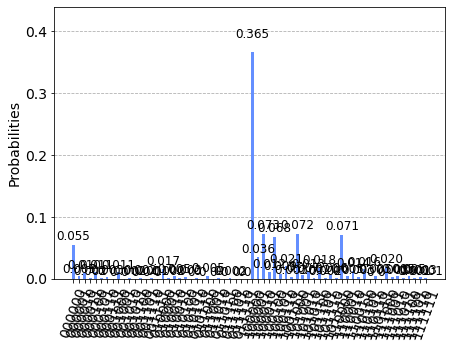

In [21]:
plot_histogram(job.result().get_counts(qc))

##### Exercício
Experimentar com outros valores de $N$. 


## Outras formas de aumentar a amplitude $c_{10}$?
O algoritmo de Grover pode ser útil aqui?

Tem como fazer o análogo sem utilizar pós-seleção?

In [4]:
import numpy as np
for j in range(0,20):
    print(np.random.randint(11))

2
6
5
0
10
6
8
8
1
8
10
3
7
6
10
10
8
10
5
10
